## Survival Analysis

In this notebook we will use Ovarian cancer dataset (Edmunson J.H. et al., 1979)

We will take advantage of these data to answer questions such as the following: 
- Do patients benefit from therapy regimen A as opposed to regimen B? Do patients’ age and fitness significantly influence the outcome?
- Is residual disease a prognostic biomarker in terms of survival?

To do this Survival Analysis we will make use of the following statstics:
- Kaplan-Meier Method and Log-Rank Test
- Cox Proportional Hazards Models

In [1]:
# Load required packages
library(survival)
library(survminer)
library(dplyr)

Loading required package: ggplot2
Loading required package: ggpubr
Loading required package: magrittr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Import the ovarian cancer dataset and have a look at it
data(ovarian)
glimpse(ovarian)

Observations: 26
Variables: 6
$ futime   <dbl> 59, 115, 156, 421, 431, 448, 464, 475, 477, 563, 638, 744, 7…
$ fustat   <dbl> 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ age      <dbl> 72.3315, 74.4932, 66.4658, 53.3644, 50.3397, 56.4301, 56.937…
$ resid.ds <dbl> 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, …
$ rx       <dbl> 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, …
$ ecog.ps  <dbl> 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, …


The futime column holds the survival times. This is the response variable. fustat, on the other hand, tells you if an individual patients’ survival time is censored. 

Note: fustat is indeed also the survival status of patients (i.e. the outcome or event). Patients who did not die will be censored after the last day of follow-up  (e.g., a patient with fustat = 0 (i.e. who survived past the last time point of follow-up) with a follow-up of 100 days will be censored after 100 days (shown as 100+)). This means that fustat also tells whether data of a patient was censored. That is because every patient who did not die will be censored eventually (at least at the end of the study).  

Apparently, the 26 patients in this study received either one of two therapy regimens (rx) and the attending physician assessed the regression of tumors (resid.ds) and patients’ performance (according to the standardized ECOG criteria; ecog.ps) at some point.

Furthermore, you get information on patients’ age and if you want to include this as a predictive variable eventually, you have to dichotomize continuous to binary values. But what cutoff should you choose for that? Let us look at the overall distribution of age values:

In [3]:
# Dichotomize age and change data labels
ovarian$rx <- factor(ovarian$rx, 
                     levels = c("1", "2"), 
                     labels = c("A", "B"))
ovarian$resid.ds <- factor(ovarian$resid.ds, 
                           levels = c("1", "2"), 
                           labels = c("no", "yes"))
ovarian$ecog.ps <- factor(ovarian$ecog.ps, 
                          levels = c("1", "2"), 
                          labels = c("good", "bad"))

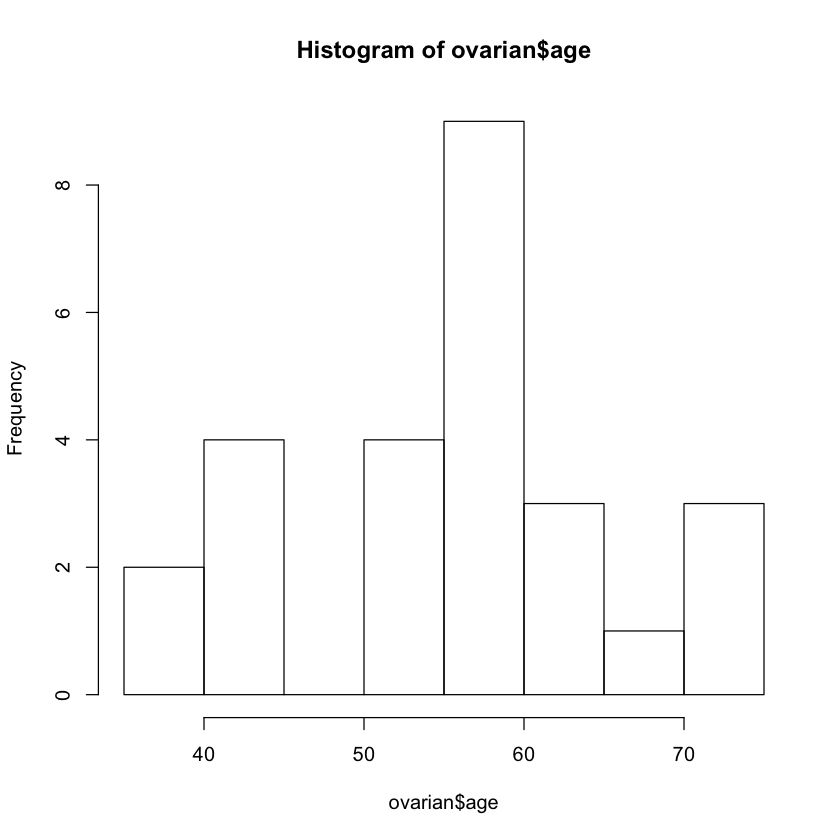

In [4]:
# Data seems to be bimodal
hist(ovarian$age) 

The obviously bi-modal distribution suggests a cutoff of 50 years. We can use the mutate function to add an additional age_group column to the data frame that will come in handy later on. 

In [5]:
# Set cutoff of 50 years.
ovarian <- ovarian %>% mutate(age_group = ifelse(age >=50, "old", "young"))

# Convert the future covariates into factors.
ovarian$age_group <- factor(ovarian$age_group)

In [6]:
# Fit survival data using the Kaplan-Meier method
surv_object <- Surv(time = ovarian$futime, event = ovarian$fustat)
surv_object 

 [1]   59   115   156   421+  431   448+  464   475   477+  563   638   744+
[13]  769+  770+  803+  855+ 1040+ 1106+ 1129+ 1206+ 1227+  268   329   353 
[25]  365   377+

A '+' behind survival times indicates censored data points.

Next step is to fit the Kaplan-Meier curves. A summary of the resulting fit object shows, among other things, survival times, the proportion of surviving patients at every time point, and treatment groups.

In [7]:
fit1 <- survfit(surv_object ~ rx, data = ovarian)
summary(fit1)

Call: survfit(formula = surv_object ~ rx, data = ovarian)

                rx=A 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
   59     13       1    0.923  0.0739        0.789        1.000
  115     12       1    0.846  0.1001        0.671        1.000
  156     11       1    0.769  0.1169        0.571        1.000
  268     10       1    0.692  0.1280        0.482        0.995
  329      9       1    0.615  0.1349        0.400        0.946
  431      8       1    0.538  0.1383        0.326        0.891
  638      5       1    0.431  0.1467        0.221        0.840

                rx=B 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
  353     13       1    0.923  0.0739        0.789        1.000
  365     12       1    0.846  0.1001        0.671        1.000
  464      9       1    0.752  0.1256        0.542        1.000
  475      8       1    0.658  0.1407        0.433        1.000
  563      7       1    0.564  0.1488        0.336        0.946


By convention, vertical lines indicate censored data, their corresponding horizontal values, the time at which censoring occurred.

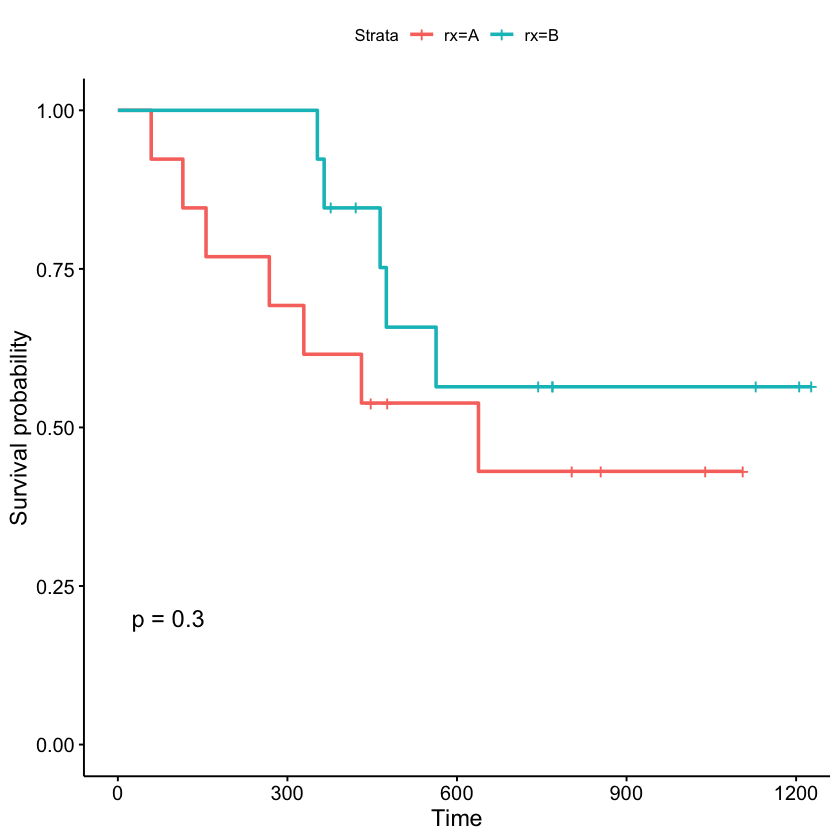

In [8]:
# Examine the corresponding survival curve
ggsurvplot(fit1, 
           data = ovarian, 
           pval = TRUE # it plots the p-value of a log-rank test as well.
          )

The log-rank p-value of 0.3 indicates a non-significant result if we consider p < 0.05 to indicate statistical significance. 

In this study, none of the treatments examined were significantly superior, although patients receiving treatment B are doing better in the first month of follow-up. 

What about the other variables?

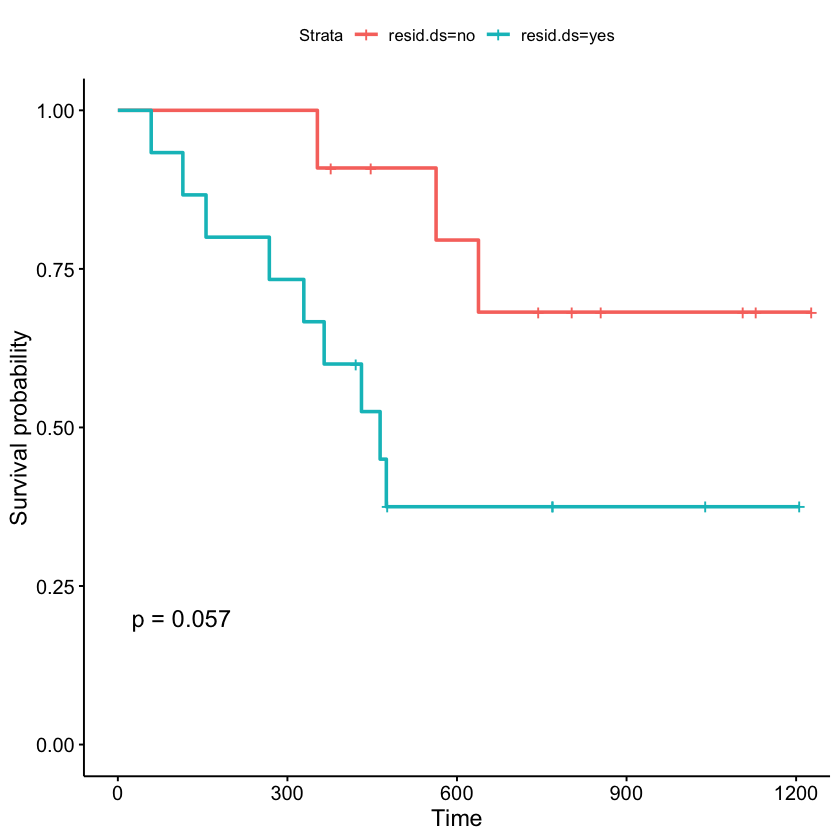

In [9]:
# Examine prdictive value of residual disease status
fit2 <- survfit(surv_object ~ resid.ds, data = ovarian)
ggsurvplot(fit2, data = ovarian, pval = TRUE)

The Kaplan-Meier plots stratified according to residual disease status look a bit different: The curves diverge early and the log-rank test is almost significant. You might want to argue that a follow-up study with an increased sample size could validate these results, that is, that patients with positive residual disease status have a significantly worse prognosis compared to patients without residual disease.


But is there a more systematic way to look at the different covariates?

We can build Cox proportional hazards models and visualize using a forest plot. It shows so-called hazard ratios (HR) which are derived from the model for all covariates that we included in the formula.

Briefly, an HR > 1 indicates an increased risk of death (according to the definition of h(t)) if a specific condition is met by a patient. An HR < 1, on the other hand, indicates a decreased risk.

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”

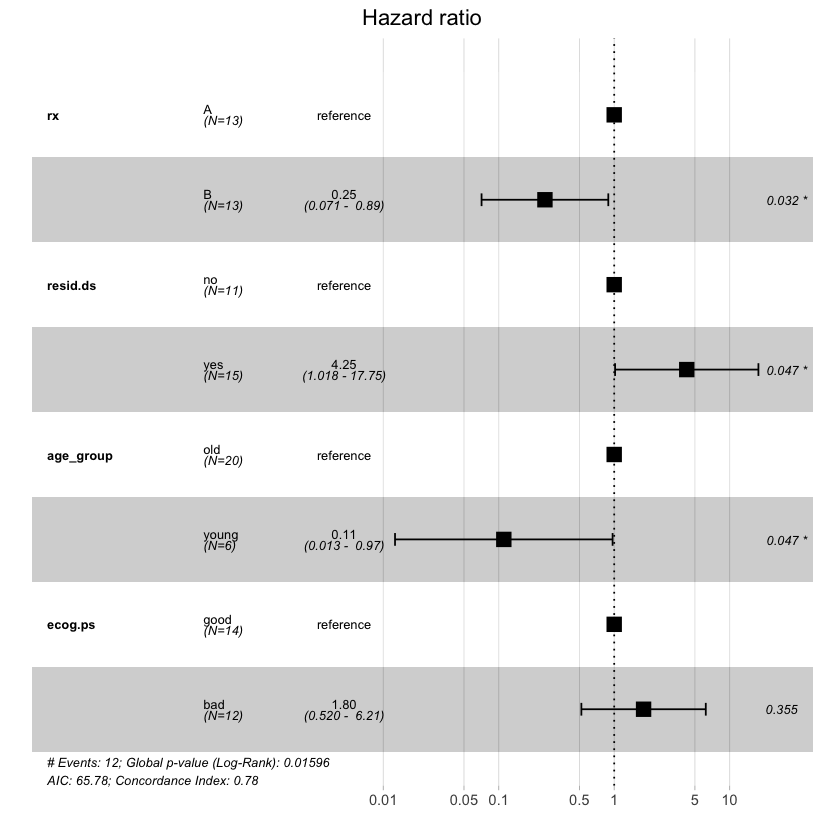

In [10]:
# Fit a Cox proportional hazards model
fit.coxph <- coxph(surv_object ~ rx + resid.ds + age_group + ecog.ps, 
                   data = ovarian)
ggforest(fit.coxph, data = ovarian)

Every HR represents a relative risk of death that compares one instance of a binary feature to the other instance. For example, a hazard ratio of 0.25 for treatment groups tells you that patients who received treatment B have a reduced risk of dying compared to patients who received treatment A (which served as a reference to calculate the hazard ratio). As shown by the forest plot, the respective 95% confidence interval is 0.071 - 0.89 and this result is significant.

## Conclusion

Using this model, you can see that the treatment group, residual disease status, and age group variables significantly influence the patients' risk of death in this study. This is quite different from what you saw with the Kaplan-Meier estimator and the log-rank test. Whereas the former estimates the survival probability, the latter calculates the risk of death and respective hazard ratios. The analysis shows that the results that these methods yield can differ in terms of significance.